Install packages

In [ ]:
#!pip install numpy
#!pip install numpy==1.19.2
!pip install investpy # https://investpy.readthedocs.io/
!pip install yfinance # https://pypi.org/project/yfinance/
!pip install hurst # https://pypi.org/project/hurst/
!pip install fathon # https://pypi.org/project/fathon/
!pip install MFDFA # https://pypi.org/project/MFDFA/
!pip install pystan==2.19.1.1
!pip install prophet #https://facebook.github.io/prophet/docs/installation.html

Import libraries

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
import investpy
import yfinance as yf
import pandas_datareader.data as web
from prophet import Prophet
from hurst import compute_Hc
#import fathon
#from fathon import fathonUtils as fu
from MFDFA import MFDFA
from MFDFA import fgn
import datetime

ONLY run the following if saving to / loading from static copy...

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
import os
curr_dir = '/content/gdrive/My Drive/Datasets'
os.chdir(curr_dir)
!ls

data_combined_daily_OHLC_logret_transposed.csv
data_combined_daily_OHLC_log_transposed.csv
data_combined_daily_OHLC_pct_transposed.csv
data_combined_daily_OHLC_transposed.csv
data_combined_daily_static.csv
winequality-red.csv


Saving...

In [32]:
t0 = datetime.datetime.now()

# stacked, raw
filename = 'data_combined_daily_static.csv'
path = curr_dir + '/' + filename
path
data_combined_daily.to_csv(path)

# OHLC transposed with hurst and trend
filename = 'data_combined_daily_OHLC_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_transposed.to_csv(path)

# percent change transposed
filename = 'data_combined_daily_OHLC_pct_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_pct_transposed.to_csv(path)

# log prices tranposed with hurst and trend
filename = 'data_combined_daily_OHLC_log_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_log_transposed.to_csv(path)

# log prices tranposed with hurst and trend
filename = 'data_combined_daily_OHLC_logret_transposed.csv'
path = curr_dir + '/' + filename
path
data_combined_daily_OHLC_logret_transposed.to_csv(path)

t0 = datetime.datetime.now() - t0
print('file save exec time: ', t0,'s')

file save exec time:  0:02:40.733980 s


Loading...

In [ ]:
# stacked, raw
filename = 'data_combined_daily_static.csv'
path = curr_dir + '/' + filename
path
data_combined_daily.to_csv(path)

data_combined_daily = pd.read_csv(path)
print(data_combined_daily.shape)
print(data_combined_daily.nunique())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,11) have mixed types.Specify dtype option on import or set low_memory=False.



(6138623, 13)
idx               731
Date              731
Open           678847
High           685383
Low            675043
Close          682401
Volume        1463007
Currency           11
name            12368
symbol          12199
symbol_cat          7
Exchange           20
OHLC          1402145
dtype: int64


# **Fetch from Investing.com API...**

Global Indices

In [3]:
indices_universe = investpy.indices.get_indices(country=None)
indices_universe['mask'] = [ len(thisSymbol) for thisSymbol in indices_universe.symbol ]
indices_major_usd = indices_universe.loc[(indices_universe['class'] == 'major_indices') & (indices_universe['currency'] == 'USD') & (indices_universe['mask'] <= 4)]
indices_usd = indices_universe.loc[(indices_universe['currency'] == 'USD')]

In [4]:
indices_universe

,country,name,full_name,symbol,currency,class,market,mask
0,argentina,S&P Merval,S&P Merval,MERV,ARS,major_indices,world_indices,4
1,argentina,BNY Mellon Argentina ADR TR,BNY Mellon Argentina ADR Total Return,BKART,USD,additional_indices,global_indices,5
2,argentina,BNY Mellon Argentina ADR,BNY Mellon Argentina ADR,BKAR,USD,additional_indices,global_indices,4
3,argentina,MAE Fixed Income,MAE Fixed Income,MAEFI,ARS,other_indices,world_indices,5
4,argentina,S&P/BYMA Argentina General,S&P/BYMA Argentina General,IBG,ARS,additional_indices,world_indices,3
...,...,...,...,...,...,...,...,...
7795,zambia,LSE All Share,LSE All Share,LASILZ,ZMW,major_indices,world_indices,6
7796,zambia,LSE EN,LSE EN,ENLZ,ZMW,additional_indices,world_indices,4
7797,zambia,LSE Inv,LSE Inv,INVLZ,ZMW,additional_indices,world_indices,5
7798,zimbabwe,Zimbabwe Mining,Zimbabwe Mining,MINZI,ZWD,additional_indices,world_indices,5


In [5]:
indices_usd

,country,name,full_name,symbol,currency,class,market,mask
1,argentina,BNY Mellon Argentina ADR TR,BNY Mellon Argentina ADR Total Return,BKART,USD,additional_indices,global_indices,5
2,argentina,BNY Mellon Argentina ADR,BNY Mellon Argentina ADR,BKAR,USD,additional_indices,global_indices,4
8,argentina,MSCI Argentina,MSCI Argentina,MIAR00000PUS,USD,major_indices,global_indices,12
55,australia,STOXX True Exposure AU 50% USD GR,STOXX True Exposure Australia 50% USD Gross Re...,SXTRUAMH,USD,other_indices,global_indices,8
56,australia,BNY Mellon Australia Classic ADR,BNY Mellon Australia Classic ADR,BKCAU,USD,additional_indices,global_indices,5
...,...,...,...,...,...,...,...,...
7789,world,MSCI Bangladesh IMI NR USD,MSCI Bangladesh IMI NR USD,MIBD000I0NUS,USD,additional_indices,global_indices,12
7791,world,MSCI World IMI,MSCI World IMI,MIWO000I0PUS,USD,additional_indices,global_indices,12
7792,world,MSCI EM Asia,MSCI EM Asia,MIMS00000PUS,USD,additional_indices,global_indices,12
7793,world,MSCI Asia Apex 50 USD,MSCI Asia Apex 50 USD,ASIAAPEX,USD,additional_indices,global_indices,8


Global Equities

In [6]:
equities_universe = investpy.stocks.get_stocks(country=None)
equities_usd = equities_universe[equities_universe['currency'] == 'USD']

In [7]:
equities_universe

,country,name,full_name,isin,currency,symbol
0,argentina,Tenaris,Tenaris,LU0156801721,ARS,TS
1,argentina,PETROBRAS ON,Petroleo Brasileiro - Petrobras,BRPETRACNOR9,ARS,APBR
2,argentina,Grupo Financiero Galicia,Grupo Financiero Galicia B,ARP495251018,ARS,GGAL
3,argentina,Ternium Argentina,Ternium Argentina SA,ARSIDE010029,ARS,TXAR
4,argentina,Pampa Energia,Pampa Energia SA,ARP432631215,ARS,PAMP
...,...,...,...,...,...,...
39947,zimbabwe,Padenga,Padenga,ZW0009012148,USD,PADENGA
39948,zimbabwe,Masimba Holdings,Masimba Holdings Limited,ZW0009012171,USD,MSHL
39949,zimbabwe,Old Mutual,Old Mutual PLC,ZAE000255360,USD,OMU
39950,zimbabwe,Proplastics,Proplastics,ZW0009012247,USD,PROL


In [8]:
equities_usd

,country,name,full_name,isin,currency,symbol
146,argentina,Alibaba Cedear,Alibaba Group Holding Ltd,ARBCOM4601T8,USD,BABA
147,argentina,Gerdau DRC,Gerdau SA,ARBCOM460200,USD,GGB
148,argentina,BRF,BRF SA,ARBCOM460218,USD,BRFS
1437,canada,Sprott Physical Gold and Silver Trust,Sprott Physical Gold and Silver Trust,CA85208R1010,USD,CEFu
1484,canada,Sprott Physical Platinum Palladium,Sprott Physical Platinum and Palladium,CA85207Q1046,USD,SPPPu
...,...,...,...,...,...,...
39946,zimbabwe,Econet Wireless Zimbabwe,Econet Wireless Zimbabwe Limited,ZW0009012122,USD,ECO
39947,zimbabwe,Padenga,Padenga,ZW0009012148,USD,PADENGA
39948,zimbabwe,Masimba Holdings,Masimba Holdings Limited,ZW0009012171,USD,MSHL
39949,zimbabwe,Old Mutual,Old Mutual PLC,ZAE000255360,USD,OMU


Exchange Traded Funds

In [9]:
etf_universe = investpy.etfs.get_etfs(country=None)
etf_usd = etf_universe[etf_universe['currency'] == 'USD']

In [10]:
etf_universe

,country,name,full_name,symbol,isin,asset_class,currency,stock_exchange,def_stock_exchange
0,australia,Australian High Interest Cash,Australian High Interest Cash,AAA,AU000000AAA3,other,AUD,Sydney,True
1,australia,VanEck Vectors MSCI International Sustainable ...,VanEck Vectors MSCI International Sustainable ...,ESGI,AU0000001356,equity,AUD,Sydney,True
2,australia,BetaShares Australian Equities Strong Bear Hedge,BetaShares Australian Equities Strong Bear Hedge,BBOZ,AU00000BBOZ2,equity,AUD,Sydney,True
3,australia,BetaShares Gold Bullion,BetaShares Gold Bullion Currency Hedged,QAU,AU000000QAU7,commodity,AUD,Sydney,True
4,australia,Vanguard Australian Shares,Vanguard Australian Shares,VAS,AU000000VAS1,equity,AUD,Sydney,True
...,...,...,...,...,...,...,...,...,...
11398,united states,Xtrackers Low Beta High Yield Bond,Xtrackers Low Beta High Yield Bond,HYDW,US2330512672,bond,USD,NYSE,True
11399,united states,Xtrackers High Beta High Yield Bond,Xtrackers High Beta High Yield Bond,HYUP,US2330512599,bond,USD,NYSE,True
11400,united states,Xtrackers Short Duration High Yield,Xtrackers Short Duration High Yield,SHYL,US2330512839,bond,USD,NYSE,True
11401,vietnam,VFMVN30,VFMVN30,E1VFVN30,VN0E1VFVN306,equity,VND,Ho Chi Minh,True


In [11]:
etf_usd

,country,name,full_name,symbol,isin,asset_class,currency,stock_exchange,def_stock_exchange
274,canada,Horizons US Dollar Currency,Horizons US Dollar Currency,DLRu,CA44049C4011,currency,USD,Toronto,False
371,canada,Brompton Global Healthcare Income & Growth,Brompton Global Healthcare Income & Growth,HIGu,CA11222T2048,equity,USD,Toronto,True
385,canada,BMO Ultra Short-Term US Bnd (USD Ac),BMO Ultra Short-Term US Bnd (USD Ac),ZUSv,CA05586U2039,bond,USD,Toronto,True
392,canada,Purpose US Cash,Purpose US Cash,PSUu,CA74640R1010,other,USD,NEO,True
425,canada,Horizons Marijuana Life Sciences,Horizons Marijuana Life Sciences Index ETF,HMMJu,CA44054J1012,equity,USD,Toronto,True
...,...,...,...,...,...,...,...,...,...
11396,united states,WisdomTree CBOE Russell 2000 PutWrite Strategy,WisdomTree CBOE Russell 2000 PutWrite Strategy,RPUT,US97717Y8407,equity,USD,NYSE,True
11397,united states,WisdomTree Europe Multifactor,WisdomTree Europe Multifactor Fund,EUMF,US97717X2559,equity,USD,NYSE,True
11398,united states,Xtrackers Low Beta High Yield Bond,Xtrackers Low Beta High Yield Bond,HYDW,US2330512672,bond,USD,NYSE,True
11399,united states,Xtrackers High Beta High Yield Bond,Xtrackers High Beta High Yield Bond,HYUP,US2330512599,bond,USD,NYSE,True


Currency Cross Pairs

In [12]:
currency_universe = investpy.currency_crosses.get_currency_crosses(base=None, second=None)
currency_usd = currency_universe[currency_universe['second'] == 'USD']

In [13]:
currency_universe

,name,full_name,base,base_name,second,second_name
0,USD/AED,USD/AED - US Dollar UAE Dirham,USD,US Dollar,AED,UAE Dirham
1,AED/JPY,AED/JPY - UAE Dirham Japanese Yen,AED,UAE Dirham,JPY,Japanese Yen
2,AED/PKR,AED/PKR - UAE Dirham Pakistani Rupee,AED,UAE Dirham,PKR,Pakistani Rupee
3,CAD/AED,CAD/AED - Canadian Dollar UAE Dirham,CAD,Canadian Dollar,AED,UAE Dirham
4,CHF/AED,CHF/AED - Swiss Franc UAE Dirham,CHF,Swiss Franc,AED,UAE Dirham
...,...,...,...,...,...,...
2026,ZAR/XAF,ZAR/XAF - South African Rand Central African F...,ZAR,South African Rand,XAF,Central African Franc
2027,ZAR/XCD,ZAR/XCD - South African Rand East Caribbean Do...,ZAR,South African Rand,XCD,East Caribbean Dollar
2028,ZAR/XOF,ZAR/XOF - South African Rand West African CFA ...,ZAR,South African Rand,XOF,West African CFA franc
2029,XAU/USD,XAU/USD - Gold Spot US Dollar,XAU,Gold Spot,USD,US Dollar


In [14]:
print(currency_usd.head(5))
print(currency_usd.tail(5))
print('shape: ',currency_usd.shape)

        name                                full_name  ... second second_name
38   AED/USD           AED/USD - UAE Dirham US Dollar  ...    USD   US Dollar
86   AFN/USD  AFN/USD - Afghanistan Afghani US Dollar  ...    USD   US Dollar
138  ARS/USD     ARS/USD - Argentinian Peso US Dollar  ...    USD   US Dollar
187  AUD/USD    AUD/USD - Australian Dollar US Dollar  ...    USD   US Dollar
358  BOB/USD   BOB/USD - Bolivian Boliviano US Dollar  ...    USD   US Dollar

[5 rows x 6 columns]
          name                            full_name  ... second second_name
2015   VND/USD  VND/USD - Vietnamese Dong US Dollar  ...    USD   US Dollar
2016   XBR/USD       XBR/USD - Brent Spot US Dollar  ...    USD   US Dollar
2017  XAGg/USD     XAGg/USD - Gram Silver US Dollar  ...    USD   US Dollar
2029   XAU/USD        XAU/USD - Gold Spot US Dollar  ...    USD   US Dollar
2030   XAG/USD      XAG/USD - Silver Spot US Dollar  ...    USD   US Dollar

[5 rows x 6 columns]
shape:  (56, 6)


Bond Yields

In [15]:
bonds_universe = investpy.bonds.get_bonds(country=None)

In [16]:
bonds_universe

,country,name,full_name
0,argentina,Argentina 1Y,Argentina 1-Year
1,argentina,Argentina 3Y,Argentina 3-Year
2,argentina,Argentina 5Y,Argentina 5 Year
3,argentina,Argentina 9Y,Argentina 9-Year
4,australia,Australia 30Y,Australia 30-Year
...,...,...,...
683,vietnam,Vietnam 3Y,Vietnam 3-Year
684,vietnam,Vietnam 2Y,Vietnam 2-Year
685,vietnam,Vietnam 1Y,Vietnam 1-Year
686,vietnam,Vietnam 5Y,Vietnam 5-Year


Commodities

In [17]:
commodities_universe = investpy.commodities.get_commodities(group=None)
commodities_borderless = commodities_universe[commodities_universe['country'].isnull()]
frames = [commodities_borderless, commodities_universe[commodities_universe['country'] == 'united states']]
commodities_borderless = pd.concat(frames)

In [18]:
commodities_universe

,title,country,name,full_name,currency,group
0,Real Time Streaming Futures Quotes,None,Gold,Gold Futures,USD,metals
1,Real Time Streaming Futures Quotes,united states,Copper,Copper Futures,USD,metals
2,Real Time Streaming Futures Quotes,None,Silver,Silver Futures,USD,metals
3,Real Time Streaming Futures Quotes,united states,Palladium,Palladium Futures,USD,metals
4,Real Time Streaming Futures Quotes,united states,Platinum,Platinum Futures,USD,metals
...,...,...,...,...,...,...
61,Real Time Streaming Futures Quotes,united states,US Soybean Meal,US Soybean Meal Futures,USD,grains
62,Real Time Streaming Futures Quotes,united states,US Soybeans,US Soybeans Futures,USD,grains
63,Real Time Streaming Futures Quotes,united states,US Wheat,US Wheat Futures,USD,grains
64,Real Time Streaming Futures Quotes,united states,US Corn,US Corn Futures,USD,grains


Cryptocurrencies

In [19]:
crypto_universe = investpy.crypto.get_cryptos()

In [20]:
crypto_universe

,name,symbol,currency
0,Bitcoin,BTC,USD
1,Ethereum,ETH,USD
2,Binance Coin,BNB,USD
3,Tether,USDT,USD
4,Cardano,ADA,USD
...,...,...,...
1032,United Bitcoin,UBTC,USD
1033,CryptoWorldX Token,CWXT,USD
1034,Cryptoindex.com 100,CIX100,USD
1035,Digital Bullion Gold,DBG,USD


# import from investing.com - daily interval - all at once!

In [21]:
t1 = datetime.datetime.now()

data_combined_daily = pd.DataFrame()

now = datetime.datetime.now()
end = str(now.day)+"/"+str(now.month)+"/"+str(now.year)
look_back_period = 365*2
min_threshold_LBP = int(0.10 * look_back_period)
start = now - datetime.timedelta(days=look_back_period)
start = str(start.day)+"/"+str(start.month)+"/"+str(start.year)

# INDICES

t0 = datetime.datetime.now()

symbols = indices_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.get_index_historical_data(index=row['name'], country=row['country'], from_date=start, to_date=end)
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'INDEX'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('indices exec time: ', t0,'s')

# EQUITIES

t0 = datetime.datetime.now()

symbols = equities_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.stocks.get_stock_historical_data(stock=row['symbol'], country=row['country'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'EQUITY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('EQUITIES exec time: ', t0,'s')

# ETF

t0 = datetime.datetime.now()

symbols = etf_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.etfs.get_etf_historical_data(etf=row['name'], country=row['country'], from_date=start, to_date=end, stock_exchange=None, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'ETF'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('ETF exec time: ', t0,'s')

# currencies

t0 = datetime.datetime.now()

symbols = currency_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.currency_crosses.get_currency_cross_historical_data(currency_cross=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'CURRENCY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)
  
t0 = datetime.datetime.now() - t0
print('currencies exec time: ', t0,'s')

# bonds

t0 = datetime.datetime.now()

symbols = bonds_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.bonds.get_bond_historical_data(bond=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'BOND_YLD'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('bonds exec time: ', t0,'s')

# commodities

t0 = datetime.datetime.now()

symbols = commodities_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.commodities.get_commodity_historical_data(commodity=row['name'], from_date=start, to_date=end, country=None, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['full_name']
    temp_df['symbol'] = row['name']
    temp_df['symbol_cat'] = 'COMMODITY'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('commodities exec time: ', t0,'s')

# crypto

t0 = datetime.datetime.now()

symbols = crypto_universe

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.crypto.get_crypto_historical_data(crypto=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df = temp_df.fillna(method='ffill')
    temp_df = temp_df.fillna(method='bfill')
    temp_df = temp_df.replace(to_replace=0, method='ffill')
    temp_df = temp_df.replace(to_replace=0, method='bfill')
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'CRYPTO'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('crypto exec time: ', t0,'s')

data_combined_daily['OHLC'] = 0.25*(data_combined_daily['Open']+data_combined_daily['High']+data_combined_daily['Low']+data_combined_daily['Close'])

data_combined_daily.reset_index(inplace=True)
data_combined_daily['idx'] = data_combined_daily['Date']
data_combined_daily = data_combined_daily.set_index('idx')

t1 = datetime.datetime.now() - t1
print('TOTAL exec time: ', t1,'s')

indices exec time:  0:24:50.080733 s
EQUITIES exec time:  0:51:41.418389 s


/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:591: Warning:

Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "united states" and default stock_exchange: "NYSE".

/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:606: Warning:

Note that the displayed information can differ depending on the stock exchange. Available stock_exchange values for "canada" are: "Toronto", "Toronto".

/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:591: Warning:

Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "united states" and default stock_exchange: "NYSE".

/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:606: Warning:

Note that the displayed information can differ depending on the stock exchange. Available stock_exchange values for "canada" are: "Toronto", "Toronto".

/usr/local/lib/python3.7/dist-packages/investpy/etfs.py:591: Warning:

Selected country does not

ETF exec time:  0:33:16.991803 s
currencies exec time:  0:01:05.072368 s
bonds exec time:  0:13:18.175855 s


/usr/local/lib/python3.7/dist-packages/investpy/commodities.py:529: Warning:

Note that the displayed commodity data can differ depending on the country. If you want to retrieve copper data from either united states or united kingdom, specify the country parameter.



commodities exec time:  0:01:15.732557 s
crypto exec time:  0:22:45.734242 s
TOTAL exec time:  2:28:13.621937 s


# import from investing.com - daily interval - piecemeal

In [ ]:
# initialise...

data_combined_daily = pd.DataFrame()

now = datetime.datetime.now()
end = str(now.day)+"/"+str(now.month)+"/"+str(now.year)
look_back_period = 365*2
min_threshold_LBP = int(0.70 * look_back_period)
start = now - datetime.timedelta(days=look_back_period)
start = str(start.day)+"/"+str(start.month)+"/"+str(start.year)

In [ ]:

# INDICES

t0 = datetime.datetime.now()

symbols = indices_usd

for index, row in symbols.iterrows():
  pass_bool_flag = False
  try:
    temp_df = investpy.get_index_historical_data(index=row['name'], country=row['country'], from_date=start, to_date=end)
    #print(temp_df.shape[0],' | ',pass_bool_flag)
  except:
    pass
    pass_bool_flag = True
  if (temp_df.shape[0] >= min_threshold_LBP) and pass_bool_flag == False:
    temp_df['name'] = row['name']
    temp_df['symbol'] = row['symbol']
    temp_df['symbol_cat'] = 'INDEX'
    frames = [data_combined_daily, temp_df]
    data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('indices exec time: ', t0,'s')


In [ ]:
data_combined_daily.shape

Open          4246
High          4259
Low           4261
Close         4186
Volume           1
Currency         1
name             9
symbol           9
symbol_cat       1
dtype: int64

In [ ]:

# EQUITIES

t0 = datetime.datetime.now()

symbols = equities_usd

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.stocks.get_stock_historical_data(stock=row['symbol'], country=row['country'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['name']
  temp_df['symbol'] = row['symbol']
  temp_df['symbol_cat'] = 'EQUITY'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('EQUITIES exec time: ', t0,'s')


EQUITIES exec time:  0:32:47.698539 s


In [ ]:
data_combined_daily.shape

(3718071, 9)

In [ ]:

# ETF

t0 = datetime.datetime.now()

symbols = etf_usd

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.etfs.get_etf_historical_data(etf=row['name'], country=row['country'], from_date=start, to_date=end, stock_exchange=None, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['name']
  temp_df['symbol'] = row['symbol']
  temp_df['symbol_cat'] = 'ETF'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('ETF exec time: ', t0,'s')


In [ ]:
data_combined_daily.shape

(5092798, 10)

In [ ]:

# currencies

t0 = datetime.datetime.now()

symbols = currency_usd

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.currency_crosses.get_currency_cross_historical_data(currency_cross=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['full_name']
  temp_df['symbol'] = row['name']
  temp_df['symbol_cat'] = 'CURRENCY'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('currencies exec time: ', t0,'s')


currencies exec time:  0:00:48.902022 s


In [ ]:
data_combined_daily.shape

(5122819, 10)

In [ ]:

# bonds

t0 = datetime.datetime.now()

symbols = bonds_universe

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.bonds.get_bond_historical_data(bond=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['full_name']
  temp_df['symbol'] = row['name']
  temp_df['symbol_cat'] = 'BOND_YLD'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('bonds exec time: ', t0,'s')


bonds exec time:  0:10:13.215571 s


In [ ]:
data_combined_daily.shape

(5482605, 10)

In [ ]:

# commodities

t0 = datetime.datetime.now()

symbols = commodities_universe

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.commodities.get_commodity_historical_data(commodity=row['name'], from_date=start, to_date=end, country=None, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['full_name']
  temp_df['symbol'] = row['name']
  temp_df['symbol_cat'] = 'COMMODITY'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('commodities exec time: ', t0,'s')


/usr/local/lib/python3.7/dist-packages/investpy/commodities.py:529: Warning:

Note that the displayed commodity data can differ depending on the country. If you want to retrieve copper data from either united states or united kingdom, specify the country parameter.



commodities exec time:  0:00:58.827349 s


In [ ]:
data_combined_daily.shape

(5515250, 10)

In [ ]:

# crypto

t0 = datetime.datetime.now()

symbols = crypto_universe

for index, row in symbols.iterrows():
  try:
    temp_df = investpy.crypto.get_crypto_historical_data(crypto=row['name'], from_date=start, to_date=end, as_json=False, order='ascending', interval='Daily')
  except:
    pass
  temp_df['name'] = row['name']
  temp_df['symbol'] = row['symbol']
  temp_df['symbol_cat'] = 'CRYPTO'
  frames = [data_combined_daily, temp_df]
  data_combined_daily = pd.concat(frames)

t0 = datetime.datetime.now() - t0
print('crypto exec time: ', t0,'s')



crypto exec time:  0:17:07.067788 s


In [ ]:
data_combined_daily['OHLC'] = 0.25*(data_combined_daily['Open']+data_combined_daily['High']+data_combined_daily['Low']+data_combined_daily['Close'])

# extract index is date column
data_combined_daily.reset_index(inplace=True)
data_combined_daily['idx'] = data_combined_daily['Date']
data_combined_daily = data_combined_daily.set_index('idx')

# Let's see what we have...

In [22]:
data_combined_daily

,Date,Open,High,Low,Close,Volume,Currency,name,symbol,symbol_cat,Exchange,OHLC
idx,,,,,,,,,,,,
2019-05-31,2019-05-31,280.450000,280.450000,280.450000,280.450000,0.0,USD,BNY Mellon Argentina ADR TR,BKART,INDEX,NaN,280.450000
2019-06-03,2019-06-03,278.660000,278.660000,278.660000,278.660000,0.0,USD,BNY Mellon Argentina ADR TR,BKART,INDEX,NaN,278.660000
2019-06-04,2019-06-04,289.450000,289.450000,289.450000,289.450000,0.0,USD,BNY Mellon Argentina ADR TR,BKART,INDEX,NaN,289.450000
2019-06-05,2019-06-05,292.610000,292.610000,292.610000,292.610000,0.0,USD,BNY Mellon Argentina ADR TR,BKART,INDEX,NaN,292.610000
2019-06-06,2019-06-06,295.480000,295.480000,295.480000,295.480000,0.0,USD,BNY Mellon Argentina ADR TR,BKART,INDEX,NaN,295.480000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26,2021-05-26,0.002151,0.002311,0.001490,0.002279,0.0,USD,Advanced Internet Blocks,AIB,CRYPTO,NaN,0.002058
2021-05-27,2021-05-27,0.002279,0.002279,0.002086,0.002160,0.0,USD,Advanced Internet Blocks,AIB,CRYPTO,NaN,0.002201
2021-05-28,2021-05-28,0.002160,0.002180,0.001842,0.001911,0.0,USD,Advanced Internet Blocks,AIB,CRYPTO,NaN,0.002023


In [23]:
data_combined_daily.shape

(6136759, 12)

In [ ]:
data_combined_daily.nunique()

Date              731
Open           680286
High           686953
Low            676433
Close          683893
Volume        1468189
Currency           11
name            12364
symbol          12194
symbol_cat          7
Exchange           20
OHLC          1525955
dtype: int64

Refactor from long to wide; then transpose.

Also note the [groupby + aggregate + unstack] method for long to wide refactoring.

https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

In [24]:
# https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

t0 = datetime.datetime.now()

temp_df = data_combined_daily[['OHLC','symbol']]
data_combined_daily_OHLC_refactored = temp_df.pivot_table(values='OHLC', index=temp_df.index, columns='symbol', aggfunc='first')
# data_combined_daily_OHLC_refactored[data_combined_daily_OHLC_refactored < 0] = 0
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.fillna(method='ffill')
#data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.replace(to_replace=0, method='ffill')
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.fillna(method='bfill')
#data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.replace(to_replace=0, method='bfill')
# data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.loc[(data_combined_daily_OHLC_refactored!=0).any(axis=1)]
# data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored[(data_combined_daily_OHLC_refactored.T != 0).any()]
data_combined_daily_OHLC_refactored = data_combined_daily_OHLC_refactored.dropna()

for column in data_combined_daily_OHLC_refactored.loc[:, (data_combined_daily_OHLC_refactored == 0).all()].columns:
  data_combined_daily_OHLC_refactored['column'] = 1

t0 = datetime.datetime.now() - t0
print('Section exec time: ', t0,'s')

Section exec time:  0:00:05.817666 s


Tranpose...

In [26]:
t0 = datetime.datetime.now()

data_combined_daily_OHLC_refactored_subset = data_combined_daily_OHLC_refactored.loc[:, (data_combined_daily_OHLC_refactored > 0).all(axis=0)]

# daily percentage change
data_combined_daily_OHLC_refactored_pct = data_combined_daily_OHLC_refactored_subset.pct_change()
data_combined_daily_OHLC_refactored_pct = data_combined_daily_OHLC_refactored_subset.dropna()

# log prices
data_combined_daily_OHLC_refactored_log = np.log(data_combined_daily_OHLC_refactored_subset)

# log returns
data_combined_daily_OHLC_refactored_log_ret = np.log(data_combined_daily_OHLC_refactored_subset) - np.log(data_combined_daily_OHLC_refactored_subset.shift(1))
data_combined_daily_OHLC_refactored_log_ret = data_combined_daily_OHLC_refactored_log_ret.fillna(method='ffill')
data_combined_daily_OHLC_refactored_log_ret = data_combined_daily_OHLC_refactored_log_ret.fillna(method='bfill')

# transpose
data_combined_daily_OHLC_transposed = data_combined_daily_OHLC_refactored_subset.T # or data_combined_daily_OHLC_refactored.transpose()
data_combined_daily_OHLC_pct_transposed = data_combined_daily_OHLC_refactored_pct.T
data_combined_daily_OHLC_log_transposed = data_combined_daily_OHLC_refactored_log.T
data_combined_daily_OHLC_logret_transposed = data_combined_daily_OHLC_refactored_log_ret.T

t0 = datetime.datetime.now() - t0
print('Section exec time: ', t0,'s')

Section exec time:  0:00:00.917957 s


In [ ]:
data_combined_daily_OHLC_log_transposed

idx,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,...,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30,2021-05-01,2021-05-02,2021-05-03,2021-05-04,2021-05-05,2021-05-06,2021-05-07,2021-05-08,2021-05-09,2021-05-10,2021-05-11,2021-05-12,2021-05-13,2021-05-14,2021-05-15,2021-05-16,2021-05-17,2021-05-18,2021-05-19,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.LMEX,7.926675,7.924109,7.924109,7.924109,7.920882,7.925700,7.916844,7.919683,7.914216,7.914216,7.914216,7.924217,7.927505,7.926278,7.925013,7.917208,7.917208,7.917208,7.918556,7.934836,7.931213,7.937482,7.932470,7.932470,7.932470,7.937696,7.951313,7.945485,7.942185,7.943996,7.943996,7.943996,7.935587,7.923384,7.928730,7.929523,7.927360,7.927360,7.927360,7.927469,...,8.283873,8.297045,8.294525,8.306003,8.306003,8.306003,8.324603,8.331707,8.338688,8.339716,8.337612,8.337612,8.337612,8.337612,8.350548,8.351634,8.365812,8.389337,8.389337,8.389337,8.384416,8.389860,8.382312,8.369250,8.366231,8.366231,8.366231,8.381282,8.384895,8.349768,8.352436,8.338760,8.338760,8.338760,8.342887,8.340719,8.346690,8.372976,8.377839,8.377839
00636K,3.028441,3.029288,3.029288,3.029288,3.027231,3.024563,3.026504,3.018594,3.018594,3.018594,3.018594,3.025776,3.039749,3.047376,3.043331,3.048206,3.048206,3.048206,3.044880,3.045712,3.066424,3.078694,3.089223,3.089223,3.089223,3.085573,3.078003,3.073619,3.079729,3.082025,3.082025,3.082025,3.111736,3.112404,3.108279,3.106043,3.104475,3.104475,3.104475,3.095464,...,3.295744,3.298888,3.300179,3.302665,3.302665,3.302665,3.310908,3.293612,3.291569,3.299534,3.299534,3.299534,3.299534,3.298057,3.291661,3.295096,3.296392,3.293612,3.293612,3.293612,3.278370,3.278370,3.288682,3.281287,3.290080,3.290080,3.290080,3.311364,3.323866,3.320349,3.319626,3.319083,3.319083,3.319083,3.310361,3.333008,3.361590,3.363149,3.364706,3.364706
00657K,3.250278,3.244738,3.244738,3.244738,3.227439,3.225752,3.244544,3.246394,3.246394,3.246394,3.246394,3.261456,3.264327,3.265378,3.257519,3.260881,3.260881,3.260881,3.262893,3.258097,3.270329,3.274500,3.272417,3.272417,3.272417,3.269189,3.266332,3.261169,3.268808,3.268808,3.268808,3.268808,3.288495,3.293241,3.288588,3.291847,3.291383,3.291383,3.291383,3.285974,...,3.578227,3.559482,3.579622,3.574590,3.574590,3.574590,3.581712,3.576550,3.575011,3.572346,3.572346,3.572346,3.572346,3.570940,3.572065,3.565581,3.582407,3.582963,3.582963,3.582963,3.590922,3.556633,3.536311,3.522825,3.534124,3.534124,3.534124,3.526361,3.553203,3.532299,3.538928,3.547316,3.547316,3.547316,3.548755,3.553060,3.556205,3.549474,3.572907,3.572907
00668K,2.177022,2.181547,2.181547,2.181547,2.162173,2.162173,2.191654,2.195000,2.195000,2.195000,2.195000,2.215937,2.221375,2.218116,2.218116,2.223542,2.223542,2.223542,2.223542,2.221375,2.231089,2.241773,2.248129,2.248129,2.248129,2.250239,2.249184,2.234306,2.237513,2.236445,2.236445,2.236445,2.247072,2.247072,2.244956,2.252344,2.253132,2.253132,2.253132,2.247072,...,2.512035,2.499795,2.509599,2.503074,2.503074,2.503074,2.509599,2.505526,2.505526,2.504709,2.504709,2.504709,2.504709,2.505526,2.507972,2.507972,2.513656,2.524127,2.524127,2.524127,2.533697,2.525729,2.509599,2.497329,2.509599,2.509599,2.509599,2.517696,2.519308,2.505526,2.503074,2.512035,2.512035,2.512035,2.506750,2.521721,2.520113,2.512846,2.529721,2.529721
0JSJ,3.259634,3.259634,3.259634,3.259634,3.259634,3.259634,3.259634,3.259634,3.259634,3.259634,3.2596

In [ ]:
sum((data_combined_daily_OHLC_refactored_subset == 0).any())

0

In [ ]:
sum(data_combined_daily_OHLC_refactored_subset.isna().any())

0

In [ ]:
sum((data_combined_daily_OHLC_refactored_subset < 0).any())

0

In [ ]:
print(data_combined_daily_OHLC_transposed.shape) # original
print(data_combined_daily_OHLC_pct_transposed.shape) # pct change
print(data_combined_daily_OHLC_log_transposed.shape) # log prices
print(data_combined_daily_OHLC_logret_transposed.shape) # log returns

(11959, 731)
(11959, 731)
(11959, 731)
(11959, 731)


In [ ]:
data_combined_daily_OHLC_refactored_log_ret

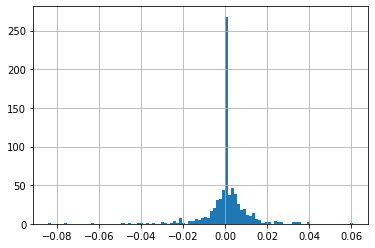

In [ ]:
hist = data_combined_daily_OHLC_refactored_log_ret['SPY'].hist(bins=100)

In [ ]:
data_combined_daily_OHLC_logret_transposed

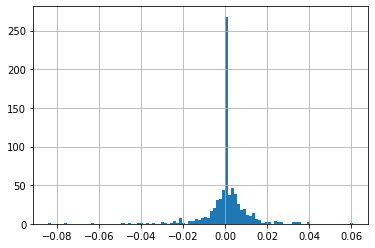

In [ ]:
hist = data_combined_daily_OHLC_logret_transposed.loc['SPY'].hist(bins=100)

Compute Hurst Exponent - this pertains to the Rescaled Range (R/S) method.

append Hc to transposed frame and cleanse.

For prices.

In [ ]:
hurst = []

for column in data_combined_daily_OHLC_refactored_subset.columns:
  subset = data_combined_daily_OHLC_refactored_subset[column]
  try:
    H, c, dataset = compute_Hc(subset, kind='price', simplified=True)
    hurst.append(H)
  except:
    hurst.append(None)

data_combined_daily_OHLC_transposed['hurst'] = [x for x in hurst]
data_combined_daily_OHLC_transposed = data_combined_daily_OHLC_transposed.dropna()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.



In [ ]:
data_combined_daily_OHLC_transposed

idx,2019-05-30 00:00:00,2019-05-31 00:00:00,2019-06-01 00:00:00,2019-06-02 00:00:00,2019-06-03 00:00:00,2019-06-04 00:00:00,2019-06-05 00:00:00,2019-06-06 00:00:00,2019-06-07 00:00:00,2019-06-08 00:00:00,2019-06-09 00:00:00,2019-06-10 00:00:00,2019-06-11 00:00:00,2019-06-12 00:00:00,2019-06-13 00:00:00,2019-06-14 00:00:00,2019-06-15 00:00:00,2019-06-16 00:00:00,2019-06-17 00:00:00,2019-06-18 00:00:00,2019-06-19 00:00:00,2019-06-20 00:00:00,2019-06-21 00:00:00,2019-06-22 00:00:00,2019-06-23 00:00:00,2019-06-24 00:00:00,2019-06-25 00:00:00,2019-06-26 00:00:00,2019-06-27 00:00:00,2019-06-28 00:00:00,2019-06-29 00:00:00,2019-06-30 00:00:00,2019-07-01 00:00:00,2019-07-02 00:00:00,2019-07-03 00:00:00,2019-07-04 00:00:00,2019-07-05 00:00:00,2019-07-06 00:00:00,2019-07-07 00:00:00,2019-07-08 00:00:00,...,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,2021-04-28 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00,2021-05-01 00:00:00,2021-05-02 00:00:00,2021-05-03 00:00:00,2021-05-04 00:00:00,2021-05-05 00:00:00,2021-05-06 00:00:00,2021-05-07 00:00:00,2021-05-08 00:00:00,2021-05-09 00:00:00,2021-05-10 00:00:00,2021-05-11 00:00:00,2021-05-12 00:00:00,2021-05-13 00:00:00,2021-05-14 00:00:00,2021-05-15 00:00:00,2021-05-16 00:00:00,2021-05-17 00:00:00,2021-05-18 00:00:00,2021-05-19 00:00:00,2021-05-20 00:00:00,2021-05-21 00:00:00,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,hurst,trend
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.LMEX,2770.20000,2763.10000,2763.100000,2763.10000,2754.200000,2767.500000,2743.100000,2750.900000,2735.90000,2735.900000,2735.900000,2763.400000,2772.500000,2769.100000,2765.600000,2744.100000,2744.10000,2744.100000,2747.800000,2792.900000,2782.800000,2800.300000,2786.300000,2786.300000,2786.300000,2800.90000,2839.300000,2822.800000,2813.500000,2818.600000,2818.600000,2818.600000,2795.000000,2761.100000,2775.900000,2778.100000,2772.100000,2772.100000,2772.100000,2772.400000,...,4001.900000,4048.100000,4048.100000,4048.100000,4124.100000,4153.500000,4182.600000,4186.900000,4178.10000,4178.1000,4178.100000,4178.10000,4232.500000,4237.100000,4297.600000,4399.900000,4399.900000,4399.900000,4378.300000,4402.200000,4369.100000,4312.400000,4299.400000,4299.400000,4299.400000,4364.600000,4380.400000,4229.200000,4240.500000,4182.900000,4182.900000,4182.900000,4200.200000,4191.100000,4216.200000,4328.500000,4349.60000,4349.600000,0.756044,Trending
00636K,20.66500,20.68250,20.682500,20.68250,20.640000,20.585000,20.625000,20.462500,20.46250,20.462500,20.462500,20.610000,20.900000,21.060000,20.975000,21.077500,21.07750,21.077500,21.007500,21.025000,21.465000,21.730000,21.960000,21.960000,21.960000,21.88000,21.715000,21.620000,21.752500,21.802500,21.802500,21.802500,22.460000,22.475000,22.382500,22.332500,22.297500,22.297500,22.297500,22.097500,...,27.117500,27.185000,27.185000,27.185000,27.410000,26.940000,26.885000,27.100000,27.10000,27.1000,27.100000,27.06000,26.887500,26.980000,27.015000,26.940000,26.940000,26.940000,26.532500,26.532500,26.807500,26.610000,26.845000,26.845000,26.845000,27.422500,27.767500,27.670000,27.650000,27.635000,27.635000,27.635000,27.395000,28.022500,28.835000,28.880000,28.92500,28.925000,0.631754,Trending
00657K,25.79750,25.65500,25.655000,25.65500,25.215000,25.172500,25.650000,25.697500,25.69750,25.697500,25.697500,26.087500,26.162500,26.190000,25.985000,26.072500,26.07250,26.072500,26.125000,26.000000,26.320000,26.430000,26.375000,26.375000,26.375000,26.29000,26.215000,26.080000,26.280000,26.280000,26.280000,26.280000,26.802500,26.930000,26.805000,26.892500,26.880000,26.880000,26.880000,26.735000,...,35.860000,35.680000,35.680000,35.680000,35.935000,35.750000,35.695000,35.600000,35.60000,35.6000,35.600000,35.55000,35.590000,35.360000,35.960000,35.980000,35.980000,35.980000,

In [ ]:
subset = data_combined_daily_OHLC_transposed['hurst']
print(subset.describe())
print('\nSkewness: ',skew(subset))
print('\nKurtosis: ',kurtosis(subset))

count    11942.000000
mean         0.679238
std          0.189172
min         -2.448876
25%          0.607037
50%          0.668528
75%          0.734272
max          3.571466
Name: hurst, dtype: float64

Skewness:  -0.7431936181140516

Kurtosis:  33.61490449157441


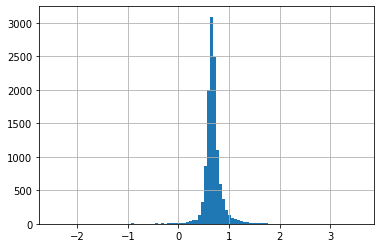

In [ ]:
hist = data_combined_daily_OHLC_transposed['hurst'].hist(bins=100)

In [ ]:
epsilon = 0.05
print('Below Range: ',subset[(subset < 0)].count())
print('Anti-Persistent (Mean-Reverting): ',subset[(subset >= 0) & (subset < 0.5 - epsilon)].count())
print('Brownian Motion: ',subset[(subset >= 0.5 - epsilon) & (subset <= 0.5 + epsilon)].count())
print('Persistent (Trending): ',subset[(subset > 0.5 + epsilon) & (subset <= 1.0)].count())
print('Above Range: ',subset[(subset > 1.0)].count())

Below Range:  71
Anti-Persistent (Mean-Reverting):  355
Brownian Motion:  914
Persistent (Trending):  10151
Above Range:  451


In [ ]:
epsilon = 0.05
trend = []

for hurst_value in data_combined_daily_OHLC_transposed['hurst']:
  if (hurst_value < 0):
    trend.append('Below_Bound')
  elif (hurst_value >= 0) & (hurst_value < 0.5 - epsilon):
    trend.append('Mean_Revert')
  elif (hurst_value >= 0.5 - epsilon) & (hurst_value <= 0.5 + epsilon):
    trend.append('Brownian')
  elif (hurst_value > 0.5 + epsilon) & (hurst_value <= 1):
    trend.append('Trending')
  elif (hurst_value > 1):
    trend.append('Above_Bound')

data_combined_daily_OHLC_transposed['trend'] = [x for x in trend]

print('Below Range: ',data_combined_daily_OHLC_transposed[data_combined_daily_OHLC_transposed['trend'] == 'Below_Bound'].shape[0])
print('Anti-Persistent (Mean-Reverting): ',data_combined_daily_OHLC_transposed[data_combined_daily_OHLC_transposed['trend'] == 'Mean_Revert'].shape[0])
print('Brownian Motion: ',data_combined_daily_OHLC_transposed[data_combined_daily_OHLC_transposed['trend'] == 'Brownian'].shape[0])
print('Persistent (Trending): ',data_combined_daily_OHLC_transposed[data_combined_daily_OHLC_transposed['trend'] == 'Trending'].shape[0])
print('Above Range: ',data_combined_daily_OHLC_transposed[data_combined_daily_OHLC_transposed['trend'] == 'Above_Bound'].shape[0])

Below Range:  71
Anti-Persistent (Mean-Reverting):  355
Brownian Motion:  914
Persistent (Trending):  10151
Above Range:  451


Hurst Exponent - log prices.

In [ ]:
hurst = []

for column in data_combined_daily_OHLC_refactored_log.columns:
  subset = data_combined_daily_OHLC_refactored_log[column]
  try:
    H, c, dataset = compute_Hc(subset, kind='price', simplified=True)
    hurst.append(H)
  except:
    hurst.append(None)

data_combined_daily_OHLC_log_transposed['hurst'] = [x for x in hurst]
data_combined_daily_OHLC_log_transposed = data_combined_daily_OHLC_log_transposed.dropna()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.



In [ ]:
data_combined_daily_OHLC_log_transposed

idx,2019-05-30 00:00:00,2019-05-31 00:00:00,2019-06-01 00:00:00,2019-06-02 00:00:00,2019-06-03 00:00:00,2019-06-04 00:00:00,2019-06-05 00:00:00,2019-06-06 00:00:00,2019-06-07 00:00:00,2019-06-08 00:00:00,2019-06-09 00:00:00,2019-06-10 00:00:00,2019-06-11 00:00:00,2019-06-12 00:00:00,2019-06-13 00:00:00,2019-06-14 00:00:00,2019-06-15 00:00:00,2019-06-16 00:00:00,2019-06-17 00:00:00,2019-06-18 00:00:00,2019-06-19 00:00:00,2019-06-20 00:00:00,2019-06-21 00:00:00,2019-06-22 00:00:00,2019-06-23 00:00:00,2019-06-24 00:00:00,2019-06-25 00:00:00,2019-06-26 00:00:00,2019-06-27 00:00:00,2019-06-28 00:00:00,2019-06-29 00:00:00,2019-06-30 00:00:00,2019-07-01 00:00:00,2019-07-02 00:00:00,2019-07-03 00:00:00,2019-07-04 00:00:00,2019-07-05 00:00:00,2019-07-06 00:00:00,2019-07-07 00:00:00,2019-07-08 00:00:00,...,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,2021-04-28 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00,2021-05-01 00:00:00,2021-05-02 00:00:00,2021-05-03 00:00:00,2021-05-04 00:00:00,2021-05-05 00:00:00,2021-05-06 00:00:00,2021-05-07 00:00:00,2021-05-08 00:00:00,2021-05-09 00:00:00,2021-05-10 00:00:00,2021-05-11 00:00:00,2021-05-12 00:00:00,2021-05-13 00:00:00,2021-05-14 00:00:00,2021-05-15 00:00:00,2021-05-16 00:00:00,2021-05-17 00:00:00,2021-05-18 00:00:00,2021-05-19 00:00:00,2021-05-20 00:00:00,2021-05-21 00:00:00,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,hurst
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.LMEX,7.926675,7.924109,7.924109,7.924109,7.920882,7.925700,7.916844,7.919683,7.914216,7.914216,7.914216,7.924217,7.927505,7.926278,7.925013,7.917208,7.917208,7.917208,7.918556,7.934836,7.931213,7.937482,7.932470,7.932470,7.932470,7.937696,7.951313,7.945485,7.942185,7.943996,7.943996,7.943996,7.935587,7.923384,7.928730,7.929523,7.927360,7.927360,7.927360,7.927469,...,8.297045,8.294525,8.306003,8.306003,8.306003,8.324603,8.331707,8.338688,8.339716,8.337612,8.337612,8.337612,8.337612,8.350548,8.351634,8.365812,8.389337,8.389337,8.389337,8.384416,8.389860,8.382312,8.369250,8.366231,8.366231,8.366231,8.381282,8.384895,8.349768,8.352436,8.338760,8.338760,8.338760,8.342887,8.340719,8.346690,8.372976,8.377839,8.377839,0.691899
00636K,3.028441,3.029288,3.029288,3.029288,3.027231,3.024563,3.026504,3.018594,3.018594,3.018594,3.018594,3.025776,3.039749,3.047376,3.043331,3.048206,3.048206,3.048206,3.044880,3.045712,3.066424,3.078694,3.089223,3.089223,3.089223,3.085573,3.078003,3.073619,3.079729,3.082025,3.082025,3.082025,3.111736,3.112404,3.108279,3.106043,3.104475,3.104475,3.104475,3.095464,...,3.298888,3.300179,3.302665,3.302665,3.302665,3.310908,3.293612,3.291569,3.299534,3.299534,3.299534,3.299534,3.298057,3.291661,3.295096,3.296392,3.293612,3.293612,3.293612,3.278370,3.278370,3.288682,3.281287,3.290080,3.290080,3.290080,3.311364,3.323866,3.320349,3.319626,3.319083,3.319083,3.319083,3.310361,3.333008,3.361590,3.363149,3.364706,3.364706,0.586730
00657K,3.250278,3.244738,3.244738,3.244738,3.227439,3.225752,3.244544,3.246394,3.246394,3.246394,3.246394,3.261456,3.264327,3.265378,3.257519,3.260881,3.260881,3.260881,3.262893,3.258097,3.270329,3.274500,3.272417,3.272417,3.272417,3.269189,3.266332,3.261169,3.268808,3.268808,3.268808,3.268808,3.288495,3.293241,3.288588,3.291847,3.291383,3.291383,3.291383,3.285974,...,3.559482,3.579622,3.574590,3.574590,3.574590,3.581712,3.576550,3.575011,3.572346,3.572346,3.572346,3.572346,3.570940,3.572065,3.565581,3.582407,3.582963,3.582963,3.582963,3.590922,3.556633,3.536311,3.522825,3.534124,3.534124,3.534124,3.526361,3.553203,3.532299,3.538928,3.547316,3.547316,3.547316,3.548755,3.553060,3.556205,3.549474,3.572907,3.572907,0.657667
00668K,2.177022,2.181547,2.181547,2.181547,2.162173,2.162173,2.191654,2.195000,2.195000,2.195000,2.195000,2.215937,2.221375,2.

In [ ]:
subset = data_combined_daily_OHLC_log_transposed['hurst']
print(subset.describe())
print('\nSkewness: ',skew(subset))
print('\nKurtosis: ',kurtosis(subset))

count    10136.000000
mean         0.593541
std          0.089714
min          0.019111
25%          0.552971
50%          0.594587
75%          0.632578
max          1.573443
Name: hurst, dtype: float64

Skewness:  0.24889442816225144

Kurtosis:  11.213255368889403


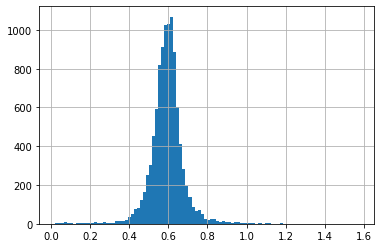

In [ ]:
hist = data_combined_daily_OHLC_log_transposed['hurst'].hist(bins=100)

In [ ]:
epsilon = 0.05
print('Below Range: ',subset[(subset < 0)].count())
print('Anti-Persistent (Mean-Reverting): ',subset[(subset >= 0) & (subset < 0.5 - epsilon)].count())
print('Brownian Motion: ',subset[(subset >= 0.5 - epsilon) & (subset <= 0.5 + epsilon)].count())
print('Persistent (Trending): ',subset[(subset > 0.5 + epsilon) & (subset <= 1.0)].count())
print('Above Range: ',subset[(subset > 1.0)].count())

Below Range:  0
Anti-Persistent (Mean-Reverting):  364
Brownian Motion:  2005
Persistent (Trending):  7736
Above Range:  31


In [ ]:
epsilon = 0.05
trend = []

for hurst_value in data_combined_daily_OHLC_log_transposed['hurst']:
  if (hurst_value < 0):
    trend.append('Below_Bound')
  elif (hurst_value >= 0) & (hurst_value < 0.5 - epsilon):
    trend.append('Mean_Revert')
  elif (hurst_value >= 0.5 - epsilon) & (hurst_value <= 0.5 + epsilon):
    trend.append('Brownian')
  elif (hurst_value > 0.5 + epsilon) & (hurst_value <= 1):
    trend.append('Trending')
  elif (hurst_value > 1):
    trend.append('Above_Bound')

data_combined_daily_OHLC_log_transposed['trend'] = [x for x in trend]

print('Below Range: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Below_Bound'].shape[0])
print('Anti-Persistent (Mean-Reverting): ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Mean_Revert'].shape[0])
print('Brownian Motion: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Brownian'].shape[0])
print('Persistent (Trending): ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Trending'].shape[0])
print('Above Range: ',data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed['trend'] == 'Above_Bound'].shape[0])

In [ ]:
data_combined_daily_OHLC_log_transposed

idx,2019-05-30 00:00:00,2019-05-31 00:00:00,2019-06-01 00:00:00,2019-06-02 00:00:00,2019-06-03 00:00:00,2019-06-04 00:00:00,2019-06-05 00:00:00,2019-06-06 00:00:00,2019-06-07 00:00:00,2019-06-08 00:00:00,2019-06-09 00:00:00,2019-06-10 00:00:00,2019-06-11 00:00:00,2019-06-12 00:00:00,2019-06-13 00:00:00,2019-06-14 00:00:00,2019-06-15 00:00:00,2019-06-16 00:00:00,2019-06-17 00:00:00,2019-06-18 00:00:00,2019-06-19 00:00:00,2019-06-20 00:00:00,2019-06-21 00:00:00,2019-06-22 00:00:00,2019-06-23 00:00:00,2019-06-24 00:00:00,2019-06-25 00:00:00,2019-06-26 00:00:00,2019-06-27 00:00:00,2019-06-28 00:00:00,2019-06-29 00:00:00,2019-06-30 00:00:00,2019-07-01 00:00:00,2019-07-02 00:00:00,2019-07-03 00:00:00,2019-07-04 00:00:00,2019-07-05 00:00:00,2019-07-06 00:00:00,2019-07-07 00:00:00,2019-07-08 00:00:00,...,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,2021-04-28 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00,2021-05-01 00:00:00,2021-05-02 00:00:00,2021-05-03 00:00:00,2021-05-04 00:00:00,2021-05-05 00:00:00,2021-05-06 00:00:00,2021-05-07 00:00:00,2021-05-08 00:00:00,2021-05-09 00:00:00,2021-05-10 00:00:00,2021-05-11 00:00:00,2021-05-12 00:00:00,2021-05-13 00:00:00,2021-05-14 00:00:00,2021-05-15 00:00:00,2021-05-16 00:00:00,2021-05-17 00:00:00,2021-05-18 00:00:00,2021-05-19 00:00:00,2021-05-20 00:00:00,2021-05-21 00:00:00,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,hurst,trend
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.LMEX,7.926675,7.924109,7.924109,7.924109,7.920882,7.925700,7.916844,7.919683,7.914216,7.914216,7.914216,7.924217,7.927505,7.926278,7.925013,7.917208,7.917208,7.917208,7.918556,7.934836,7.931213,7.937482,7.932470,7.932470,7.932470,7.937696,7.951313,7.945485,7.942185,7.943996,7.943996,7.943996,7.935587,7.923384,7.928730,7.929523,7.927360,7.927360,7.927360,7.927469,...,8.294525,8.306003,8.306003,8.306003,8.324603,8.331707,8.338688,8.339716,8.337612,8.337612,8.337612,8.337612,8.350548,8.351634,8.365812,8.389337,8.389337,8.389337,8.384416,8.389860,8.382312,8.369250,8.366231,8.366231,8.366231,8.381282,8.384895,8.349768,8.352436,8.338760,8.338760,8.338760,8.342887,8.340719,8.346690,8.372976,8.377839,8.377839,0.691899,Trending
00636K,3.028441,3.029288,3.029288,3.029288,3.027231,3.024563,3.026504,3.018594,3.018594,3.018594,3.018594,3.025776,3.039749,3.047376,3.043331,3.048206,3.048206,3.048206,3.044880,3.045712,3.066424,3.078694,3.089223,3.089223,3.089223,3.085573,3.078003,3.073619,3.079729,3.082025,3.082025,3.082025,3.111736,3.112404,3.108279,3.106043,3.104475,3.104475,3.104475,3.095464,...,3.300179,3.302665,3.302665,3.302665,3.310908,3.293612,3.291569,3.299534,3.299534,3.299534,3.299534,3.298057,3.291661,3.295096,3.296392,3.293612,3.293612,3.293612,3.278370,3.278370,3.288682,3.281287,3.290080,3.290080,3.290080,3.311364,3.323866,3.320349,3.319626,3.319083,3.319083,3.319083,3.310361,3.333008,3.361590,3.363149,3.364706,3.364706,0.586730,Trending
00657K,3.250278,3.244738,3.244738,3.244738,3.227439,3.225752,3.244544,3.246394,3.246394,3.246394,3.246394,3.261456,3.264327,3.265378,3.257519,3.260881,3.260881,3.260881,3.262893,3.258097,3.270329,3.274500,3.272417,3.272417,3.272417,3.269189,3.266332,3.261169,3.268808,3.268808,3.268808,3.268808,3.288495,3.293241,3.288588,3.291847,3.291383,3.291383,3.291383,3.285974,...,3.579622,3.574590,3.574590,3.574590,3.581712,3.576550,3.575011,3.572346,3.572346,3.572346,3.572346,3.570940,3.572065,3.565581,3.582407,3.582963,3.582963,3.582963,3.590922,3.556633,3.536311,3.522825,3.534124,3.534124,3.534124,3.526361,3.553203,3.532299,3.538928,3.547316,3.547316,3.547316,3.548755,3.553060,3.556205,3.549474,3.572907,3.572907,0.657667,Trending
00668K,2.177022,2.181547,2.181547,2.181547,2.162173,2.162173,2.191654,2.195000,2.195000,2.195000,2.195000,2.215937,2.221375,2.218116,2.21811

#Learnin' Time!

In [ ]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import metrics
import scipy.stats as stats

In [ ]:
X = data_combined_daily_OHLC_log_transposed[data_combined_daily_OHLC_log_transposed.columns.tolist()[:-2]]
X_scaled = StandardScaler().fit_transform(X)
y = data_combined_daily_OHLC_log_transposed.trend

n_iters = 50
sensitivity = np.array([])
precision = np.array([])
accuracy = np.array([])
F1 = np.array([])

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for k in range(0,n_iters):
  random_state = np.random.randint(low=1, high=9999999)
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3,random_state=random_state)

  lr = LogisticRegression(C=1e9,solver='lbfgs')
  lr.fit(X_train,y_train)
  y_test_pred = lr.predict(X_test)

  sensitivity = np.append(sensitivity,metrics.recall_score(y_test,y_test_pred,average='weighted'))
  precision = np.append(precision,metrics.precision_score(y_test,y_test_pred,average='weighted'))
  accuracy = np.append(accuracy,metrics.accuracy_score(y_test,y_test_pred))
  F1 = np.append(F1,metrics.f1_score(y_test,y_test_pred,average='weighted'))

print("Sensitivity/Recall (TPR): ", np.mean(sensitivity))
print("Precision (PPV): ", np.mean(precision))
print("Accuracy: ", np.mean(accuracy))
print("F1:", np.mean(F1))

Sensitivity/Recall (TPR):  0.7605392962841171
Precision (PPV):  0.697741622911103
Accuracy:  0.7605392962841171
F1: 0.6981907817076148


In [ ]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

Most frequent class dummy classifier test accuracy:  0.7546859585662611


In [ ]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.02208202, 0.01104101, 0.96687697],
       [0.0625    , 0.07142857, 0.86607143],
       [0.0204793 , 0.00305011, 0.97647059]])

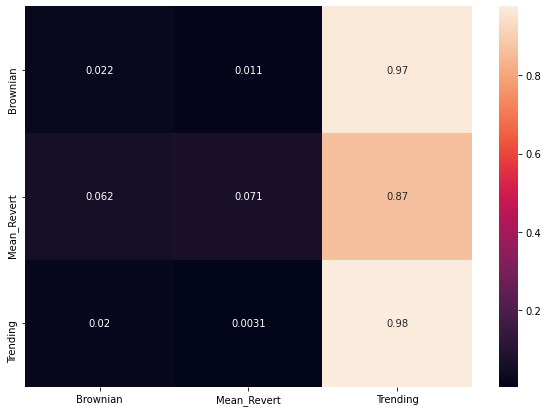

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in ['Brownian','Mean_Revert','Trending']],
                  columns = [i for i in ['Brownian','Mean_Revert','Trending']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
# https://stats.stackexchange.com/questions/91044/how-to-calculate-precision-and-recall-in-a-3-x-3-confusion-matrix

print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='weighted'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='weighted'))
print("Accuracy: ", metrics.accuracy_score(y_test,y_test_pred))
print("F1:", metrics.f1_score(y_test,y_test_pred,average='weighted'))

Sensitivity/Recall (TPR):  0.7441631042420257
Precision (PPV):  0.6294271384867478
Accuracy:  0.7441631042420257
F1: 0.6574906570083118


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [ ]:
data = data_combined_daily_OHLC_log_transposed.iloc[:, [0] + [-2,-1]]
data.columns = ['x', 'y']
data['cluster'] = [x for x in kmeans.labels_]

import plotly.express as px

fig = px.scatter(data, x='x', y='y', color="cluster")

fig.show()

In [ ]:
data = data_combined_daily_OHLC_log_transposed.iloc[:, [0] + [-3,-2,-1]]
data

idx,2019-05-30 00:00:00,2021-05-29 00:00:00,hurst,trend
symbol,,,,
.LMEX,7.926675,8.377839,0.691899,Trending
00636K,3.028441,3.364706,0.586730,Trending
00657K,3.250278,3.572907,0.657667,Trending
00668K,2.177022,2.529721,0.628926,Trending
0JSJ,3.259634,3.935935,0.605430,Trending
...,...,...,...,...
ZUSv,3.918800,3.941485,0.613696,Trending
ZVO,1.433893,0.824175,0.763548,Trending
Zinc,7.844265,8.027171,0.619027,Trending
